In [1]:
from skimage import io,filters, morphology, measure, draw,exposure
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import trackpy as tp
import pandas as pd
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
from skimage.filters import threshold_otsu, threshold_multiotsu
import seaborn as sns
from tqdm import tqdm

In [2]:
PATH = "</PATH/TO/DIR/>WAVE/Molecular_counting/Lamellipodia/"

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def kde_estimation(data,bins,bandwidth):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(np.array(data)[:, np.newaxis])
    X_plot = np.linspace(np.min(data), np.max(data), bins)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    return log_dens,X_plot

In [5]:
def seg_cells(image, threshold, sigma,min_size, max_size, plot = True):
    """
    Segment out regions with a given fluorescence threshold in a cell
 
    Parameters
    ----------
    image : 2D array
        Raw tif image (single frame).
    threshold: float
        threshold used for segmentation
    sigma: float
        Standard deviation for Gaussian kernel.The larger the value, the smoothier the gaussian fitting.
    min_size: float
        minimum size of the segmented region
    max_size: float
        maximum size of the segmented region
    plot: bool
        whether or not plot the segmentation image
    
    Returns
    -------
    region_properties: list of RegionProperties
        Each item describes one labeled region with the corresponding attributes. 
    label_mask_clean:2D array 
        Segmentations based on fluorescent intensities of the image. 
        Each integer corresponds to a unique segmentation and 0 is the background.
        
    """
    smooth = filters.gaussian(image,sigma,preserve_range=True)
    cell_mask = smooth > threshold
    label_mask = measure.label(cell_mask)
    region_properties = measure.regionprops(label_mask)  
    label_mask_clean = label_mask.copy()
    for r in region_properties:
        if r.area <= min_size or r.area >= max_size:
            label_mask_clean[label_mask_clean == r.label] = 0
    if plot:
        plt.figure(figsize = (10,10))
        plt.imshow(image)
        plt.contour(label_mask_clean,colors = 'red',linewidths = 0.7)

    region_properties = measure.regionprops(label_mask_clean,intensity_image=image)
    return region_properties,label_mask_clean

In [6]:
def cal_background(image,threshold,sigma,plot = False):
    smooth = filters.gaussian(image,sigma,preserve_range=True)
    cell_mask = smooth >threshold
    background_mask = ~cell_mask
    label_mask = measure.label(cell_mask)
    region_properties = measure.regionprops(label_mask) 
    background_array = background_mask * image
    background = background_array[np.nonzero(background_array)].mean()
    if plot:
        plt.figure(figsize = (10,10))
#         plt.imshow(image)
        plt.imshow(background_mask)

    region_properties = measure.regionprops(label_mask,intensity_image=image)
    return background

In [8]:
image = io.imread(PATH +'example_images/231031_fmlp_3_1_SIR.tif')

In [9]:
image.shape

(5, 1024, 1024)

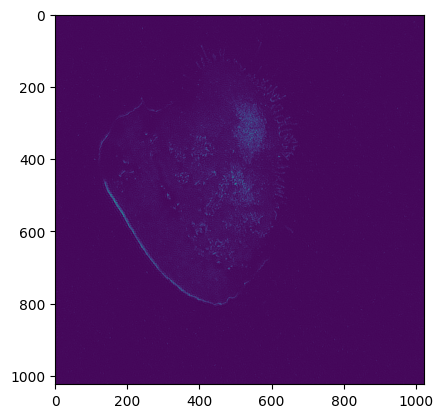

In [10]:
plt.imshow(image[0])

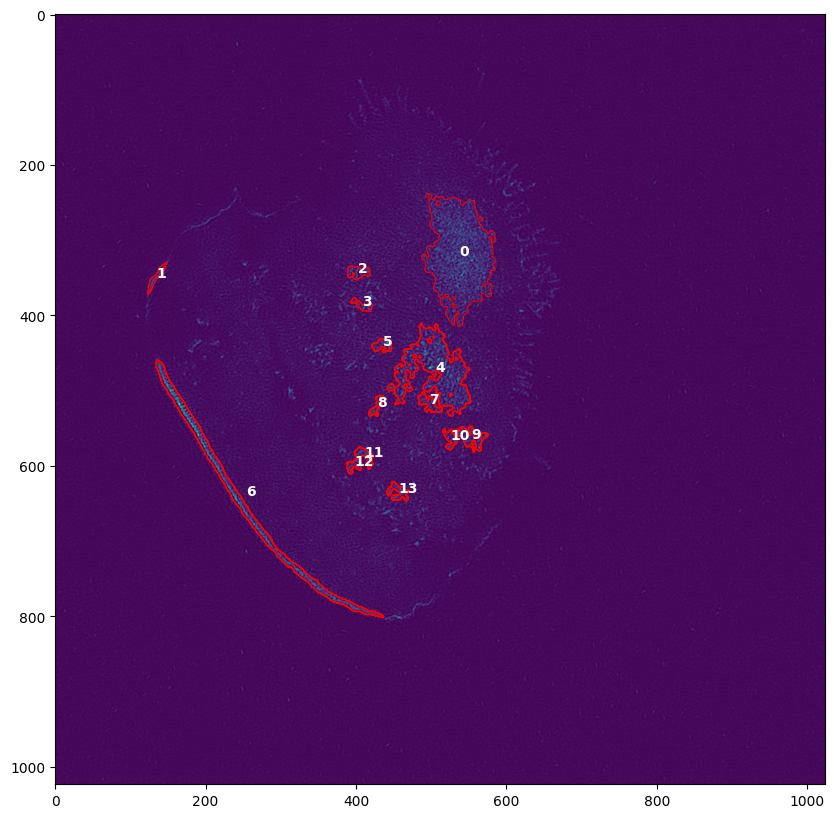

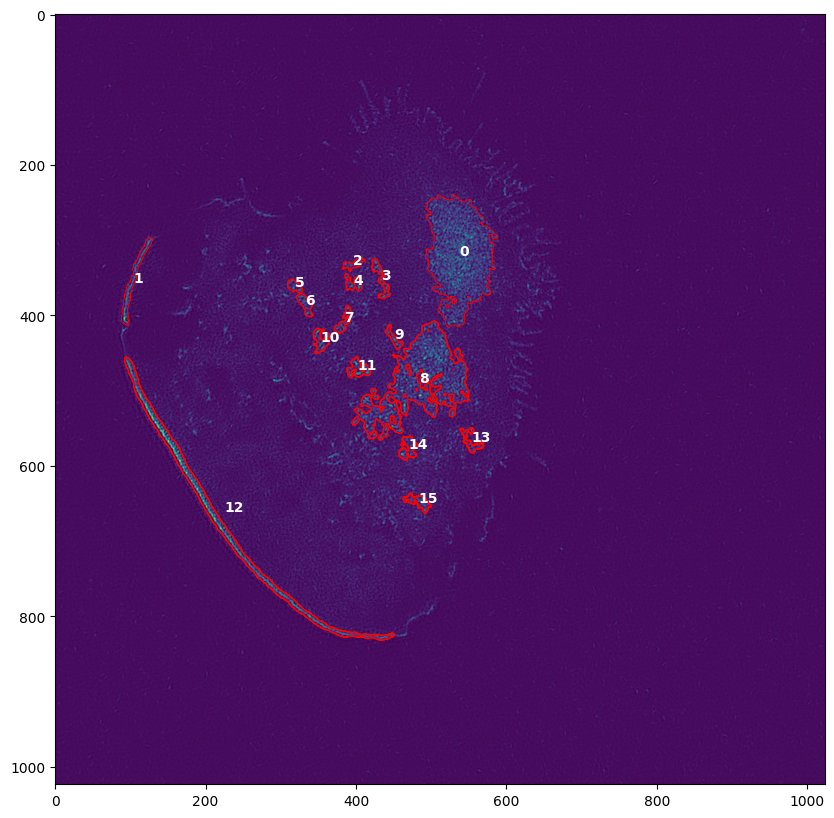

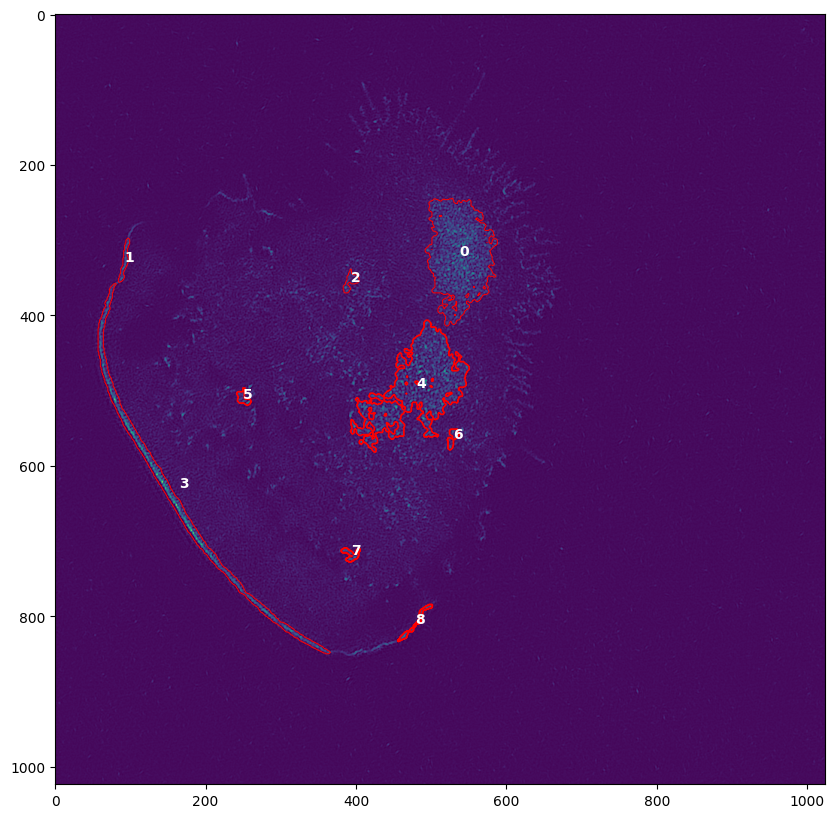

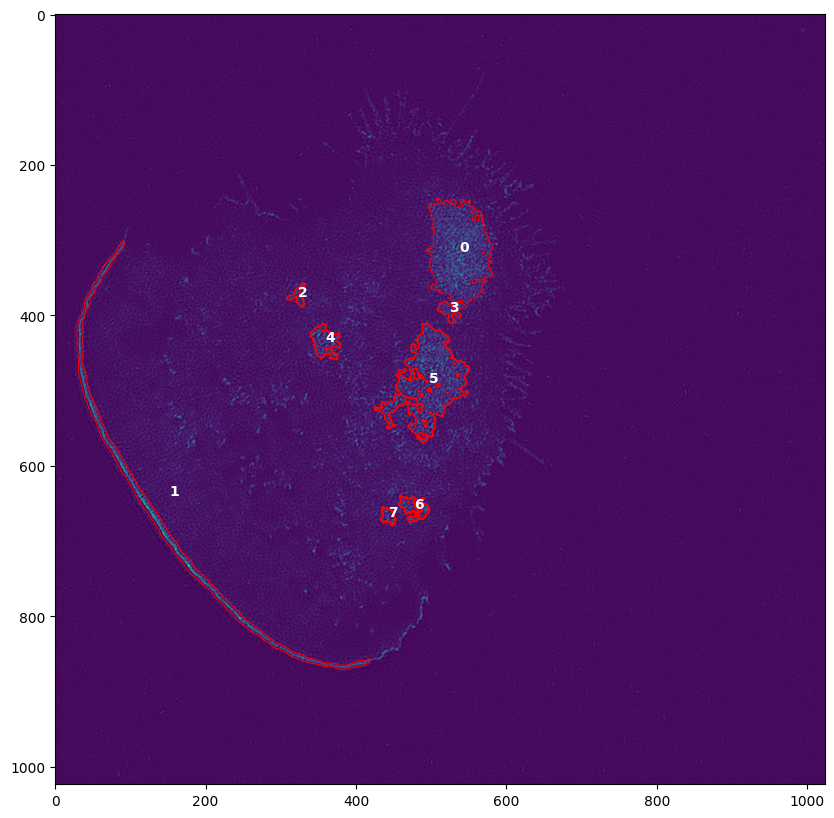

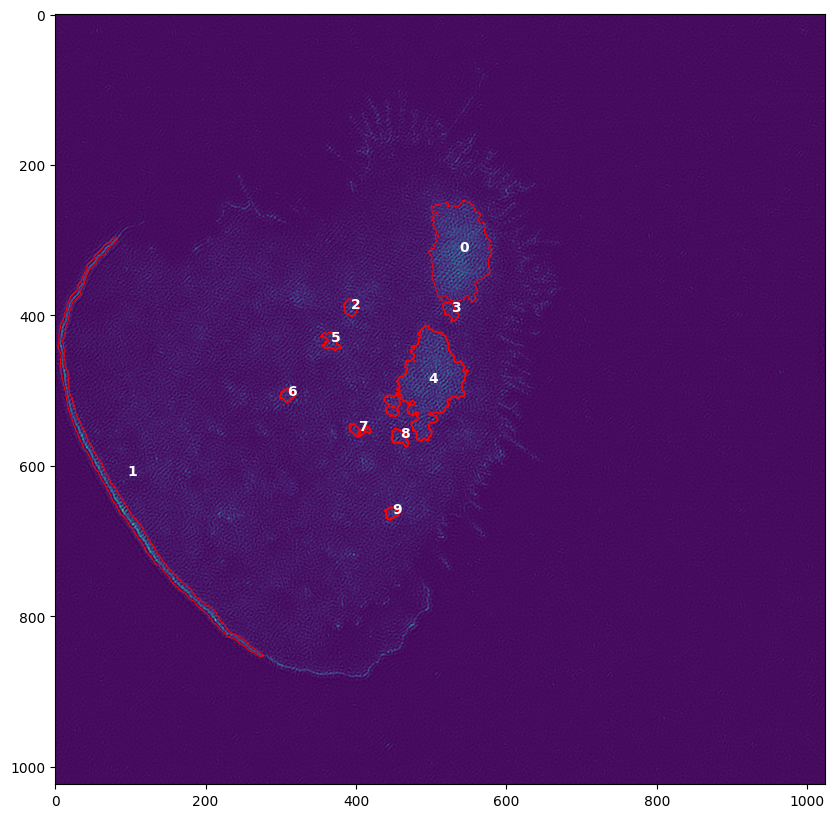

In [11]:
# Segmentation of lamellipodia for quantification
lamelli = pd.DataFrame()
p = 0
threshold = threshold_otsu(image)
sigma = 2
# manually picl out the lammelipodia
num =[[6],[12],[3],[1],[1]]
for i in range(image.shape[0]):
    prop,label_mask_clean = seg_cells(image[i],threshold,sigma,200,100000,True)
    background = cal_background(image[i],threshold,sigma)
    for r in range(len(prop)): 
        y_center, x_center = prop[r].centroid # note that image coordinates are often given as (y, x) rather than (x, y)
        plt.text(x_center, y_center,r, fontweight = 'bold', color = 'white')

    for n in num[i]:
        lamelli.at[p,'intensity'] = prop[n].intensity_image.sum()
        lamelli.at[p,'area'] = prop[n].area
        lamelli.at[p,'perimeter'] = prop[n].perimeter_crofton
        lamelli.at[p,'label'] = n
        lamelli.at[p,'frame'] = i
        lamelli.at[p,'background'] = prop[n].area*background
        lamelli.at[p,'final_intensity'] = prop[n].intensity_image.sum() - prop[n].area*background
        p += 1

In [12]:
lamelli

intensity    area    perimeter  label  frame     background  \
0  9.545812e+05  4120.0   955.638315    6.0    0.0  159568.918304   
1  1.039812e+06  4498.0  1112.579228   12.0    1.0  176502.454109   
2  1.004314e+06  4629.0  1238.032049    3.0    2.0  180536.226837   
3  1.114263e+06  5265.0  1572.905936    1.0    3.0  207586.941147   
4  8.643234e+05  4815.0  1369.768056    1.0    4.0  194770.059872   

   final_intensity  
0    795012.331696  
1    863309.108391  
2    823778.085663  
3    906676.183853  
4    669553.377628

### 

# Generate plots

In [13]:
total1 = pd.read_csv(PATH + 'csv_data/lamel_g1.csv',index_col=0)
total2 = pd.read_csv(PATH + 'csv_data/lamel_g2.csv',index_col=0)
total3 = pd.read_csv(PATH + 'csv_data/lamel_g3.csv',index_col=0)

In [14]:
total = total1
total = total.append(total2)
total = total.append(total3)

In [15]:
#Convert pixel number to micron
total['length(um)'] = total['perimeter']/2*0.04

In [16]:
total['unit_length_intensity'] = total.final_intensity/total['length(um)']

In [17]:
# Convert fluorescent intensity to number of molecules based on the standard curve(38.8), 
# corrected by fluorescence loss after fixation (33.7/31.8) and percentage of eGFP-tagged subunits (0.88)
total['count'] = total.unit_length_intensity/(38.8*(33.7/31.8))/0.88

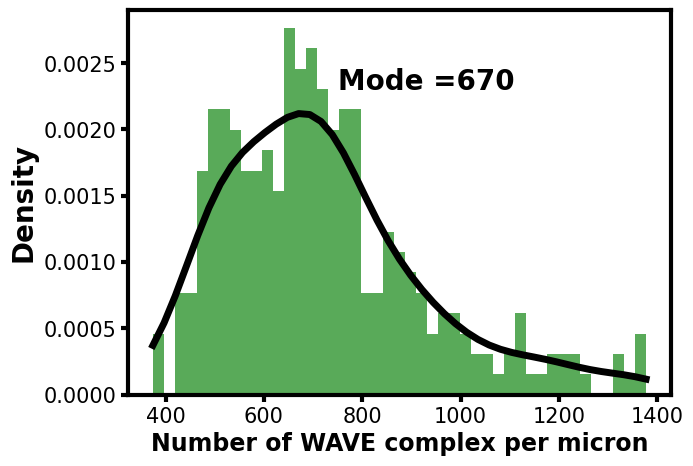

In [18]:
#Fig. 4 C
# Molecular counting of the WAVE complex at the tips of lammelipodia
fig,ax = plt.subplots(figsize = (7,5))
distribution = total['count']
bins = 45
bandwidth = 70
log_dens,X_plot = kde_estimation(distribution,bins,bandwidth)
plt.hist(distribution,bins =bins,density = True,color = '#138613',alpha = 0.7)
plt.plot(X_plot[:, 0], np.exp(log_dens)[:],'-',color = 'black',lw = 5,alpha = 1)
plt.xlabel('Number of WAVE complex per micron',size = 17,fontweight = 'bold')
plt.ylabel('Density',size = 20,fontweight = 'bold')
mode = X_plot[log_dens.argmax()]
plt.text(750,0.0023,"Mode ="+ f'{float(f"{mode[0]:.2g}"):g}',size = 20,weight = 'bold')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3,size = 5)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.savefig(PATH + 'Fig4C_lamellipodia_count.png',dpi = 300,bbox_inches = 'tight')